From the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs studied on viral organisms associated with sexually transmitted diseases, such as Human Immunodeficiency Virus (HIV). This subset is saved in the same `.tsv` file format as the original database.

For more details on the extraction process, refer to [`./src/data/std_extraction.ipynb`](./src/data/std_extraction.ipynb).


In [1]:
#import libraries and scripts

import pandas as pd
import numpy as np
from src.utils import data_utils, evaluation_utils, general_utils

In [2]:
#read the std database

df = pd.read_csv('BindingSTD.tsv', sep = '\t', on_bad_lines='skip', low_memory = False)

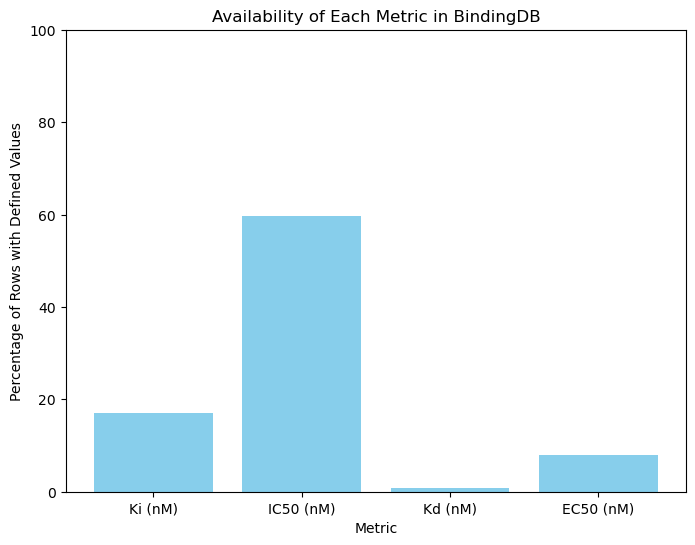

In [3]:
evaluation_utils.plot_metric_availability(df)

We observe that IC50 is given in more than 50% of the rows, while the other metric are less represented. We will select only rows with this metric for our analyses

In [4]:
df = data_utils.select_metric(df, 'IC50 (nM)')
df = data_utils.clean_na_columns(df)
df.shape

(18026, 27)